#[01] Bidirectional LSTM - Named Entity Recognition

##(1) Data loading and Tokenizing

In [1]:
import urllib.request
import numpy as np
from tqdm import tqdm
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20RNN%20Sequence%20Labeling/dataset/train.txt",
                           filename="train.txt")

('train.txt', <http.client.HTTPMessage at 0x7b3052a25f30>)

In [3]:
f = open('train.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ')
    splits[-1] = re.sub(r'\n', '', splits[-1])
    word = splits[0].lower()
    sentence.append([word, splits[-1]])

print('Total sample count :', len(tagged_sentences))

Total sample count : 14041


In [4]:
print(tagged_sentences[0])

[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


In [5]:
sentences, ner_tags = [], []
for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence))
    ner_tags.append(list(tag_info))

print(sentences[0])
print(ner_tags[0])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


In [6]:
print(sentences[12])
print(ner_tags[12])

['only', 'france', 'and', 'britain', 'backed', 'fischler', "'s", 'proposal', '.']
['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(sentences, ner_tags, test_size=.2, random_state=777)

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [9]:
print('Train data count :', len(X_train))
print('Val data count :', len(X_valid))
print('Test data count :', len(X_test))
print('Train label count :', len(y_train))
print('Val label count :', len(y_valid))
print('Test label count :', len(y_test))

Train data count : 8985
Val data count : 2247
Test data count : 2809
Train label count : 8985
Val label count : 2247
Test label count : 2809


In [10]:
for sent in X_train[:2]:
    print(sent)

['young', 'boys', '9', '1', '0', '8', '6', '19', '3']
['hentgen', '(', '17-7', ')', 'surrendered', 'just', 'three', 'doubles', 'and', 'a', 'pair', 'of', 'singles', 'in', 'tossing', 'his', 'major-league', 'leading', 'ninth', 'complete', 'game', '.']


##(2) Vocab

In [11]:
word_list = []
for sent in X_train:
    for word in sent:
        word_list.append(word)

word_counts = Counter(word_list)
print('Total word count :', len(word_counts))

Total word count : 16742


In [12]:
print("Frequency of word 'the' in train dataset :", word_counts['the'])
print("Frequency of word 'love' in train dataset :", word_counts['love'])

Frequency of word 'the' in train dataset : 5410
Frequency of word 'love' in train dataset : 7


In [13]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('Most frequent 10 words')
print(vocab[:10])

Most frequent 10 words
['the', ',', '.', 'of', 'in', 'to', 'a', ')', '(', 'and']


In [14]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

for index, word in enumerate(vocab):
    word_to_index[word] = index + 2

vocab_size = len(word_to_index)
print('Vocabulary size with padding & unk tokens :', vocab_size)

Vocabulary size with padding & unk tokens : 16744


In [15]:
print('word <PAD> index :', word_to_index['<PAD>'])
print('word <UNK> index :', word_to_index['<UNK>'])
print("word 'the' index :", word_to_index['the'])

word <PAD> index : 0
word <UNK> index : 1
word 'the' index : 2


##(3) Encoding

In [16]:
def texts_to_sequences(tokenized_X_data, word_to_index):
    encoded_X_data = []
    for sent in tokenized_X_data:
        index_sequences = []
        for word in sent:
            try:
                index_sequences.append(word_to_index[word])
            except KeyError:
                index_sequences.append(word_to_index['<UNK>'])
        encoded_X_data.append(index_sequences)

    return encoded_X_data

In [17]:
encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_valid, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

In [18]:
for sent in encoded_X_train[:2]:
    print(sent)

[1260, 3215, 117, 17, 21, 123, 56, 539, 23]
[5456, 10, 8229, 9, 8230, 186, 84, 1815, 11, 8, 1073, 5, 421, 6, 8231, 35, 2043, 291, 790, 957, 267, 4]


In [19]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('Original sample :', X_train[0])
print('Decoded sample :', decoded_sample)

Original sample : ['young', 'boys', '9', '1', '0', '8', '6', '19', '3']
Decoded sample : ['young', 'boys', '9', '1', '0', '8', '6', '19', '3']


In [20]:
flatten_tags = [tag for sent in y_train for tag in sent]
tag_vocab = list(set(flatten_tags))
print('Tag set :', tag_vocab)
print('Size of tag set :', len(tag_vocab))

Tag set : ['B-PER', 'I-MISC', 'O', 'B-LOC', 'I-ORG', 'I-PER', 'B-ORG', 'I-LOC', 'B-MISC']
Size of tag set : 9


In [21]:
tag_to_index = {}
tag_to_index['<PAD>'] = 0

for index, word in enumerate(tag_vocab):
    tag_to_index[word] = index + 1

tag_vocab_size = len(tag_to_index)
print('Tag set :', tag_to_index)

Tag set : {'<PAD>': 0, 'B-PER': 1, 'I-MISC': 2, 'O': 3, 'B-LOC': 4, 'I-ORG': 5, 'I-PER': 6, 'B-ORG': 7, 'I-LOC': 8, 'B-MISC': 9}


In [22]:
def encoding_label(sequence, tag_to_index):
    label_sequence = []
    for seq in sequence:
        label_sequence.append([tag_to_index[tag] for tag in seq])
    return label_sequence

In [23]:
encoded_y_train = texts_to_sequences(y_train, tag_to_index)
encoded_y_valid = texts_to_sequences(y_valid, tag_to_index)
encoded_y_test = texts_to_sequences(y_test, tag_to_index)

In [24]:
print('X data')
print(encoded_X_train[:2])
print('-' * 49)
print('y data')
print(encoded_y_train[:2])
print('-' * 49)
print('First sample & label length')
print(len(encoded_X_train[0]))
print(len(encoded_y_train[0]))

X data
[[1260, 3215, 117, 17, 21, 123, 56, 539, 23], [5456, 10, 8229, 9, 8230, 186, 84, 1815, 11, 8, 1073, 5, 421, 6, 8231, 35, 2043, 291, 790, 957, 267, 4]]
-------------------------------------------------
y data
[[7, 5, 3, 3, 3, 3, 3, 3, 3], [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]]
-------------------------------------------------
First sample & label length
9
9


##(4) Padding

Max length of samples : 78
Average length of samples : 14.518420


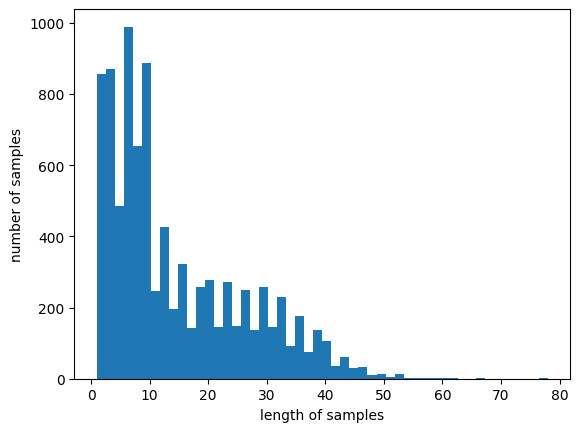

In [25]:
print('Max length of samples : %d' % max(len(l) for l in encoded_X_train))
print('Average length of samples : %f' % (sum(map(len, encoded_X_train)) / len(encoded_X_train)))

plt.hist([len(s) for s in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [26]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if (len(sentence) <= max_len):
            count += 1
    print('Ratio of samples length below %s : %s' %(max_len, (count / len(nested_list) * 100)))

In [27]:
max_len = 80
below_threshold_len(max_len, encoded_X_train)

Ratio of samples length below 80 : 100.0


In [28]:
def pad_sequences(sentences, max_len):
    features = np.zeros((len(sentences), max_len), dtype=int)
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, :len(sentence)] = np.array(sentence)[:max_len]
    return features

In [29]:
padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

padded_y_train = pad_sequences(encoded_y_train, max_len=max_len)
padded_y_valid = pad_sequences(encoded_y_valid, max_len=max_len)
padded_y_test = pad_sequences(encoded_y_test, max_len=max_len)

print('Train data size :', padded_X_train.shape)
print('Valid data size :', padded_X_valid.shape)
print('Test data size :', padded_X_test.shape)
print('-' * 30)
print('Train label size :', padded_y_train.shape)
print('Valid label size :', padded_y_valid.shape)
print('Test label size :', padded_y_test.shape)

Train data size : (8985, 80)
Valid data size : (2247, 80)
Test data size : (2809, 80)
------------------------------
Train label size : (8985, 80)
Valid label size : (2247, 80)
Test label size : (2809, 80)


In [30]:
print('Train data samples')
print(padded_X_train[:2])
print('-' * 11 + ' Label ' + '-' * 11)
print(padded_y_train[:2])

Train data samples
[[1260 3215  117   17   21  123   56  539   23    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [5456   10 8229    9 8230  186   84 1815   11    8 1073    5  421    6
  8231   35 2043  291  790  957  267    4    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]]
----------- Label -----------
[[7 5 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

## (5) Modeling

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [33]:
class NERTagger(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2):
        super(NERTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x) # (batch_size, seq_length, embedding_dim)
        lstm_out, _ = self.lstm(embedded) # (batch_size, seq_length, hidden_dim*2)
        logits = self.fc(lstm_out) # (batch_size, seq_length, output_dim)
        return logits

In [34]:
X_train_tensor = torch.tensor(padded_X_train, dtype=torch.long)
y_train_tensor = torch.tensor(padded_y_train, dtype=torch.long)
X_valid_tensor = torch.tensor(padded_X_valid, dtype=torch.long)
y_valid_tensor = torch.tensor(padded_y_valid, dtype=torch.long)
X_test_tensor = torch.tensor(padded_X_test, dtype=torch.long)
y_test_tensor = torch.tensor(padded_y_test, dtype=torch.long)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)
valid_dataset = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=False, batch_size=32)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=32)

In [35]:
print('Vocabulary size :', vocab_size)

Vocabulary size : 16744


In [36]:
embedding_dim = 100
hidden_dim = 256
output_dim = tag_vocab_size
learning_rate = 0.01
num_epochs = 10
num_layers = 2

In [37]:
# Model, loss, optimizer
model = NERTagger(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers)
model.to(device)

NERTagger(
  (embedding): Embedding(16744, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [38]:
criterion = nn.CrossEntropyLoss(ignore_index=0)  # not calculating loss for padding token.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

##(6) Evaluation

In [39]:
def calculate_accuracy(logits, labels, ignore_index=0):
    predicted = torch.argmax(logits, dim=1)

    mask = (labels != ignore_index)

    correct = (predicted == labels).masked_select(mask).sum().item()
    total = mask.sum().item()

    accuracy = correct / total
    return accuracy

In [40]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            logits = model(batch_X)
            loss = criterion(logits.view(-1, output_dim), batch_y.view(-1))

            val_loss += loss.item()
            val_correct += calculate_accuracy(logits.view(-1, output_dim), batch_y.view(-1)) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy

##(7) Training

In [41]:
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        logits = model(batch_X)

        loss = criterion(logits.view(-1, output_dim), batch_y.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += calculate_accuracy(logits.view(-1, output_dim), batch_y.view(-1)) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'\nEpoch {epoch+1} / {num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    print('-' * 99)

    # Save checkpoint
    if val_loss < best_val_loss:
        print(f'\nValidation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving checkpoint...')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')
        print('-' * 99)


Epoch 1 / 10:
Train Loss: 0.3584, Train Accuracy: 0.9000
Validation Loss: 0.2015, Validation Accuracy: 0.9424
---------------------------------------------------------------------------------------------------

Validation loss improved from inf to 0.2015. Saving checkpoint...
---------------------------------------------------------------------------------------------------

Epoch 2 / 10:
Train Loss: 0.1115, Train Accuracy: 0.9672
Validation Loss: 0.1674, Validation Accuracy: 0.9549
---------------------------------------------------------------------------------------------------

Validation loss improved from 0.2015 to 0.1674. Saving checkpoint...
---------------------------------------------------------------------------------------------------

Epoch 3 / 10:
Train Loss: 0.0502, Train Accuracy: 0.9847
Validation Loss: 0.1754, Validation Accuracy: 0.9557
---------------------------------------------------------------------------------------------------

Epoch 4 / 10:
Train Loss: 0.0

##(8) Model loading and evaluation

In [42]:
model.load_state_dict(torch.load('best_model_checkpoint.pth'))
model.to(device)

val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')
print()

test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {test_loss:.4f}')
print(f'Best model test accuracy: {test_accuracy:.4f}')

Best model validation loss: 0.1674
Best model validation accuracy: 0.9549

Best model test loss: 0.1618
Best model test accuracy: 0.9554


##(9) Inference & Test

In [43]:
index_to_tag  = {}
for key, value in tag_to_index.items():
    index_to_tag[value] = key

def predict_labels(text, model, word_to_idx, index_to_tag, max_len=150):
    tokens = text.split()

    token_indices = [word_to_idx.get(token, 1) for token in tokens]

    token_indices_padded = np.zeros(max_len, dtype=int)
    token_indices_padded[:len(token_indices)] = token_indices[:max_len]

    input_tensor = torch.tensor(token_indices_padded, dtype=torch.long).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)

    predicted_indices = torch.argmax(logits, dim=-1).squeeze(0).tolist()

    predicted_indices_no_pad = predicted_indices[:len(tokens)]

    predicted_tags = [index_to_tag[index] for index in predicted_indices_no_pad]

    return predicted_tags

In [44]:
print(X_test[0])

['feyenoord', 'rotterdam', 'suffered', 'an', 'early', 'shock', 'when', 'they', 'went', '1-0', 'down', 'after', 'four', 'minutes', 'against', 'de', 'graafschap', 'doetinchem', '.']


In [45]:
sample = ' '.join(X_test[0])
print(sample)

feyenoord rotterdam suffered an early shock when they went 1-0 down after four minutes against de graafschap doetinchem .


In [46]:
predicted_tags = predict_labels(sample, model, word_to_index, index_to_tag)
print('Predict :', predicted_tags)
print('True value :', y_test[0])

Predict : ['B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'B-PER', 'B-LOC', 'O']
True value : ['B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O']
